## Подготовка данных

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.utils import shuffle

import re
import nltk
from nltk.corpus import wordnet
from nltk.corpus import stopwords as nltk_stopwords

from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline


from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier, Pool

from sklearn import metrics
from sklearn.metrics import f1_score

import warnings
warnings.filterwarnings('ignore')

In [2]:
try:
    comments = pd.read_csv('C:/Users/School252/Downloads/toxic_comments.csv') 
except:
    comments = pd.read_csv('/datasets/toxic_comments.csv')

In [3]:
comments.head()

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0


In [4]:
comments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


In [5]:
comments.describe()

,Unnamed: 0,toxic
count,159292.000000,159292.000000
mean,79725.697242,0.101612
std,46028.837471,0.302139
min,0.000000,0.000000
25%,39872.750000,0.000000
50%,79721.500000,0.000000
75%,119573.250000,0.000000
max,159450.000000,1.000000


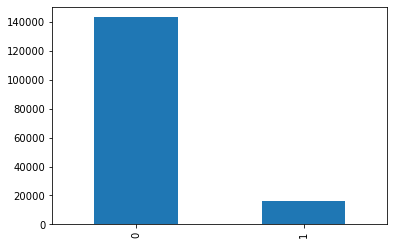

In [6]:
# проверяем баланс целевой переменной
comments['toxic'].value_counts().plot.bar();

In [7]:
print('Ко-во пропусков:\n', comments.isna().sum())

Ко-во пропусков:
 Unnamed: 0    0
text          0
toxic         0
dtype: int64


In [8]:
print('Кол-во дубликатов:', comments.duplicated().sum())

Кол-во дубликатов: 0


- датасет не содержит пропусков и дубликатов
- колонка 'Unnamed: 0' не нужна
- тексты приведены на английском языке
- баланс целевого признака соотносится как 8 к 1 (87% записей с позитивной коннотацией, 13% записей с токсичной)

In [9]:
comments = comments.drop('Unnamed: 0', axis=1)
comments.shape

(159292, 2)

In [10]:
comments['text'] = comments['text'].apply(lambda x: x.lower())

In [11]:
def clear_text(text):
    text =  re.sub('[^A-Za-z0-9]+', ' ', text)
    text = ' '.join(text.split())
    return text

In [12]:
comments['text'] = comments['text'].apply(clear_text) 

In [13]:
comments

,text,toxic
0,explanation why the edits made under my userna...,0
1,d aww he matches this background colour i m se...,0
2,hey man i m really not trying to edit war it s...,0
3,more i can t make any real suggestions on impr...,0
4,you sir are my hero any chance you remember wh...,0
...,...,...
159287,and for the second time of asking when your vi...,0
159288,you should be ashamed of yourself that is a ho...,0
159289,spitzer umm theres no actual article for prost...,0
159290,and it looks like it was actually you who put ...,0


In [14]:
corpus = list(comments['text'])

In [15]:
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

In [16]:
def clear_text(text):
    y=re.sub(r"[^'a-zA-Z ]", ' ', text) 
    k=" ".join(y.split())
    return k

In [17]:
from nltk.corpus import wordnet
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

In [18]:
test = "The striped bats are hanging on their feet for best"
print([lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in nltk.word_tokenize(test)])

['The', 'strip', 'bat', 'be', 'hang', 'on', 'their', 'foot', 'for', 'best']


In [19]:
%%time

from tqdm.notebook import tqdm
tqdm.pandas()

def lemmafunction(textc):
    k=[]
    for i in nltk.word_tokenize(textc):
        y=lemmatizer.lemmatize(i, get_wordnet_pos(i))
        k.append(y)
    return ' '.join(k) 

lemy=[]
for i in tqdm(range(len(corpus))):
    
    lemy.append(lemmafunction(clear_text(corpus[i])))
comments['lemm_text']=pd.Series(lemy, index=comments.index)

  0%|          | 0/159292 [00:00<?, ?it/s]

CPU times: total: 3h 18min 13s
Wall time: 3h 21min 45s


<div class="alert" style="background-color:#ead7f7;color:#8737bf">
    <font size="3"><b>Очень полезная вещь, спасибо. Доработал функцию обработки текста</b></font>

In [20]:
display(comments.head())
display(comments.shape)

,text,toxic,lemm_text
0,explanation why the edits made under my userna...,0,explanation why the edits make under my userna...
1,d aww he matches this background colour i m se...,0,d aww he match this background colour i m seem...
2,hey man i m really not trying to edit war it s...,0,hey man i m really not try to edit war it s ju...
3,more i can t make any real suggestions on impr...,0,more i can t make any real suggestion on impro...
4,you sir are my hero any chance you remember wh...,0,you sir be my hero any chance you remember wha...


(159292, 3)

In [21]:
features = comments.drop(['toxic'], axis=1)
target = comments['toxic']

In [27]:
features_train, features_test, target_train, target_test = train_test_split(features, 
                                                                              target, 
                                                                              test_size=.1, 
                                                                              random_state=12345)

## Векторизация текста

In [23]:
nltk.download('stopwords') 
stop_words = set(nltk_stopwords.words('english'))

[nltk_data] Error loading stopwords: [WinError 10053] Программа на
[nltk_data]     вашем хост-компьютере разорвала установленное
[nltk_data]     подключение


In [24]:
corpus_lemm_train = features_train['lemm_text']
corpus_lemm_train.shape

(143362,)

In [25]:
count_tf_idf = TfidfVectorizer(stop_words=stop_words, analyzer='word') 
tf_idf = count_tf_idf.fit_transform(corpus_lemm_train) 
tf_idf.shape

(143362, 142204)

In [28]:
corpus_lemm_test = features_test['lemm_text']
corpus_lemm_test.shape

(15930,)

In [29]:
tf_test = count_tf_idf.transform(corpus_lemm_test)
tf_test.shape

(15930, 142204)

## Обучение моделей

## LogisticRegression

In [30]:
model = LogisticRegression(random_state=12345, solver='liblinear', class_weight='balanced')
parametrs = [{'C':[0.1, 1, 10],
             'max_iter': range (10,15,2)}]

grid_lr = GridSearchCV(model, parametrs, scoring='f1_weighted', cv=5)

grid_lr.fit(tf_idf, target_train)

grid_lr.best_params_

print('f1_score', grid_lr.best_score_)

f1_score 0.9488217853570585


## CatBoost

In [31]:
model = CatBoostClassifier(silent=True, random_seed=12345)

parameters = {'learning_rate': np.logspace(-3, 0, 5),
              'iterations': range(20, 60, 20),
              'depth': range(5,10,2),
              'class_weights':([(1, 1), (1, 11)])}

grid_cbc = GridSearchCV(model, parameters, scoring='f1_weighted', cv=5, n_jobs=-1)

grid_cbc.fit(tf_idf, target_train)

grid_cbc.best_params_

print('f1_score', grid_cbc.best_score_)
#{'class_weights': (1, 1), 'depth': 5, 'iterations': 40, 'learning_rate': 0.001}


KeyboardInterrupt



## Анализ моделей

In [32]:
prediction = grid_lr.predict(tf_test)
print('f1_score на тестовой выборке:', f1_score(target_test, prediction))

f1_score на тестовой выборке: 0.7605793808577109


В проекте был выбран метод векторизации tf idf, который на модели Логистической Регрессии показал приближенный к лучшему результат предсказаний по метрике F1.

- по результатам оценки взвешенной метрики F1 на валидационной выборке победила модель Логистической Регрессии
- по результатам обучения и предсказания на тестовой выборке победившая модель логистической Регрессии достигла ожидаемого в данном проекте скора F1 = 0.76 (выше, чем 0.75)

## Чек-лист проверки

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [х]  Jupyter Notebook открыт
- [х]  Весь код выполняется без ошибок
- [х]  Ячейки с кодом расположены в порядке исполнения
- [х]  Выполнена загрузка и подготовка данных
- [х]  Выполнено обучение моделей
- [х]  Есть анализ скорости работы и качества моделей